In [ ]:
!pip install mesa

In [ ]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement, TextElement
from mesa.visualization.ModularVisualization import ModularServer
from mesa.datacollection import DataCollector

Used the Previous Assignments Code Here



In [ ]:
import mesa
import numpy as np

import mesa
import numpy as np


class Boid(mesa.Agent):
    """
    A Boid-style flocker agent.

    The agent follows three behaviors to flock:
        - Cohesion: steering towards neighboring agents.
        - Separation: avoiding getting too close to any other agent.
        - Alignment: try to fly in the same direction as the neighbors.

    Boids have a vision that defines the radius in which they look for their
    neighbors to flock with. Their speed (a scalar) and velocity (a vector)
    define their movement. Separation is their desired minimum distance from
    any other Boid.
    """

    def __init__(
        self,
        unique_id,
        model,
        pos,
        speed,
        velocity,
        vision,
        separation,
        cohere=0.025,
        separate=0.25,
        match=0.04,
        color = 1,
        steps_as_red = 0
        
    ):
        """
        Create a new Boid flocker agent.

        Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Boids.
            separation: Minimum distance to maintain from other Boids.
            cohere: the relative importance of matching neighbors' positions
            separate: the relative importance of avoiding close neighbors
            match: the relative importance of matching neighbors' headings
        """
        super().__init__(unique_id, model)
        self.pos = np.array(pos)
        self.speed = speed
        self.velocity = velocity
        self.vision = vision
        self.separation = separation
        self.cohere_factor = cohere
        self.separate_factor = separate
        self.match_factor = match
        self.color = color
        self.steps_as_red = steps_as_red
        
        
    def steps_as_red(self):
        return self.steps_as_red


    def color(self):
        return self.color

        
    def cohere(self, neighbors):
        """
        Return the vector toward the center of mass of the local neighbors.
        """
        cohere = np.zeros(2)
        if neighbors:
            for neighbor in neighbors:
                cohere += self.model.space.get_heading(self.pos, neighbor.pos)
            cohere /= len(neighbors)
        return cohere

    def separate(self, neighbors):
        """
        Return a vector away from any neighbors closer than separation dist.
        """
        me = self.pos
        them = (n.pos for n in neighbors)
        separation_vector = np.zeros(2)
        for other in them:
            if self.model.space.get_distance(me, other) < self.separation:
                separation_vector -= self.model.space.get_heading(me, other)
        return separation_vector

    def match_heading(self, neighbors):
        """
        Return a vector of the neighbors' average heading.
        """
        match_vector = np.zeros(2)
        if neighbors:
            for neighbor in neighbors:
                match_vector += neighbor.velocity
            match_vector /= len(neighbors)
        return match_vector

    def step(self):
        """
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        """

        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
     
        
        if self.color == 2:
            nearby_boids = self.model.space.get_neighbors(self.pos, 2, False)
            for boid in nearby_boids:
                if boid.color == 1:
                    boid.color = 2
        
        if self.color == 2:
            self.steps_as_red += 1
                    
        if self.steps_as_red == 25 and self.color == 2:
               self.color = 3


        self.velocity += (
            self.cohere(neighbors) * self.cohere_factor
            + self.separate(neighbors) * self.separate_factor
            + self.match_heading(neighbors) * self.match_factor
        ) / 2
        self.velocity /= np.linalg.norm(self.velocity)
        new_pos = self.pos + self.velocity * self.speed
        self.model.space.move_agent(self, new_pos)

        

class BoidFlockers(mesa.Model):
    """
    Flocker model class. Handles agent creation, placement and scheduling.
    """

    def __init__(
        self,
        population=100,
        width=100,
        height=100,
        speed=1,
        vision=10,
        separation=2,
        cohere=0.025,
        separate=0.25,
        match=0.04,
        red_boids= 0,
        green_boids = 0
       
    ):
        """
        Create a new Flockers model.

        Args:
            population: Number of Boids
            width, height: Size of the space.
            speed: How fast should the Boids move.
            vision: How far around should each Boid look for its neighbors
            separation: What's the minimum distance each Boid will attempt to
                    keep from any other
            cohere, separate, match: factors for the relative importance of
                    the three drives."""
        self.population = population
        self.vision = vision
        self.speed = speed
        self.separation = separation
        self.schedule = mesa.time.RandomActivation(self)
        self.space = mesa.space.ContinuousSpace(width, height, True)
        self.factors = dict(cohere=cohere, separate=separate, match=match)
        self.make_agents()
        self.running = True,
        self.red_boids = red_boids,
        self.green_boids = green_boids
 
        
       
        self.datacollector = DataCollector(
            {
                "Red": lambda m: m.count_boids_by_color(2),
                "Green": lambda m: m.count_boids_by_color(3),
            }
        )

        self.color_chart = ChartModule(
            [{"Label": "Red", "Color": "red"}, {"Label": "Green", "Color": "green"}],
            data_collector_name="datacollector",
            canvas_height=200,
            canvas_width=400,
        )

        


    def count_boids_by_color(self, color):
        """Count the number of boids of a given color"""
        return len([boid for boid in self.schedule.agents if boid.color == color])
   
   

 
    def make_agents(self):
        """
        Create self.population agents, with random positions and starting headings.
    
        """
          
        x = self.random.random() * self.space.x_max
        y = self.random.random() * self.space.y_max
        pos = np.array((x, y))
        velocity = np.random.random(2) * 2 - 1
        boid = Boid(100,self, pos,  self.speed, velocity, self.vision,self.separation, **self.factors)
        boid.color = 2
        self.space.place_agent(boid, pos)
        self.schedule.add(boid)
            
    
        for i in range(self.population-1):
            x = self.random.random() * self.space.x_max
            y = self.random.random() * self.space.y_max
            pos = np.array((x, y))
            velocity = np.random.random(2) * 2 - 1
            boid = Boid( i,self, pos,  self.speed, velocity, self.vision,self.separation, **self.factors
                
            )
            self.space.place_agent(boid, pos)
            self.schedule.add(boid)
           
    
    def step(self):
       self.datacollector.collect(self)
       self.schedule.step()
       

In [ ]:
def draw_boids(model):
    xb_vals =[]; yb_vals = []
    xr_vals =[]; yr_vals = []
    xg_vals =[]; yg_vals = []
    for boid in model.schedule.agents:
        if (boid.color == 1):
            x, y = boid.pos
            xb_vals.append(x)
            yb_vals.append(y)   
        elif (boid.color == 2):
            x, y = boid.pos
            xr_vals.append(x)
            yr_vals.append(y)   
        elif (boid.color == 3):
            x, y = boid.pos
            xg_vals.append(x)
            yg_vals.append(y)
           
    fig = plt.figure(figsize = (7,7))
    ax = fig.add_subplot(111)
    ax.scatter(xr_vals, yr_vals, c= 'r')
    ax.scatter(xb_vals, yb_vals, c= 'b')
    ax.scatter(xg_vals, yg_vals, c= 'g')

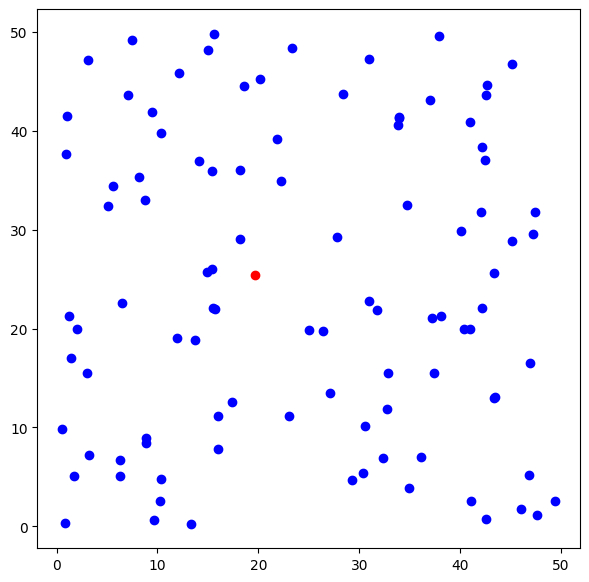

In [ ]:
model = BoidFlockers(100, 50,50, 1,5,1)
draw_boids(model)

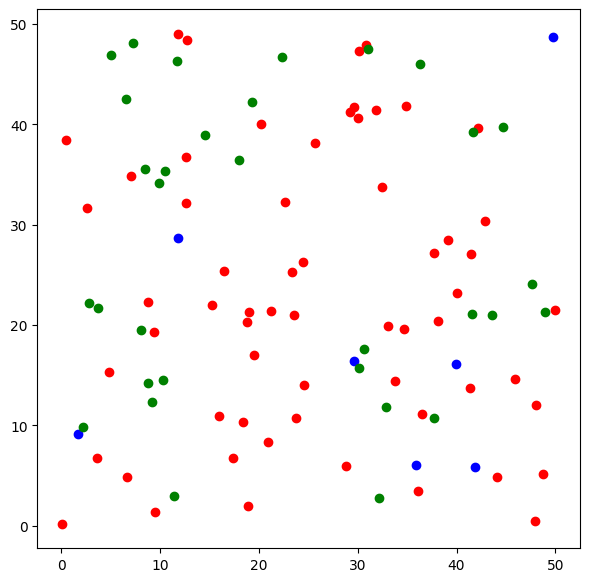

In [ ]:
for i in range(50):
    model.step()
draw_boids(model)

Using Batch Run Function

In [ ]:
results = mesa.batch_run(
    BoidFlockers, 
    parameters= {"width": 50, "height": 50, "speed": np.arange(1.0, 5.2, 0.2)},
    iterations=30, 
    max_steps=150,
    number_processes=1, 
    data_collection_period=1, 
    display_progress=True, 
) 

resultsDataframe = pd.DataFrame(results)
resultsDataframe.head(20)

100%|██████████| 630/630 [42:32<00:00,  4.05s/it]


,RunId,iteration,Step,width,height,speed,Red,Green
0,0,0,0,50,50,1.0,1,0
1,0,0,1,50,50,1.0,1,0
2,0,0,2,50,50,1.0,1,0
3,0,0,3,50,50,1.0,1,0
4,0,0,4,50,50,1.0,1,0
5,0,0,5,50,50,1.0,2,0
6,0,0,6,50,50,1.0,3,0
7,0,0,7,50,50,1.0,5,0
8,0,0,8,50,50,1.0,5,0
9,0,0,9,50,50,1.0,5,0


Storing acquired data

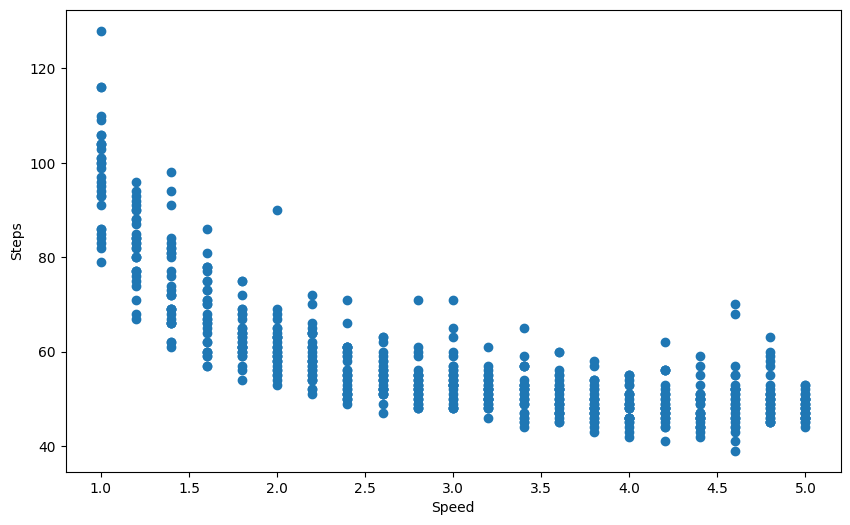

<Axes: title={'center': 'Step'}, xlabel='speed'>

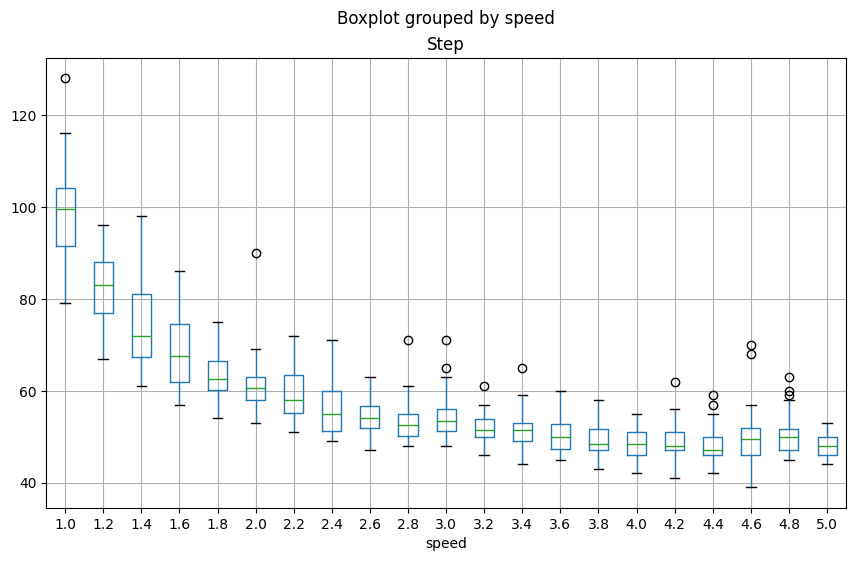

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = []

for i in range(len(results)):
    row = results[i]
    speed = round(row["speed"], 1)
    filldata = np.nan
    for j in range(150):
        Red = row["Red"]
        if i !=0:
            prev =  results[i-1]
        if Red == 0 and prev["Red"] > 0:
            filldata = row["Step"]
            break
    data.append({"speed": speed, "Step": filldata})

scatterPlot = [d["speed"] for d in data]
steps = [d["Step"] for d in data]
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(scatterPlot , steps)
ax.set_ylabel("Steps")
ax.set_xlabel("Speed")
plt.show()

result_BP = pd.DataFrame(data)
result_BP.boxplot(column= "Step", by="speed", figsize=(10,6))


When the boids move faster, it takes less time for all the red boids to turn green. This is evident from both the line plot and the scatter plot. The reason for this result is that the faster-moving boids interact differently with their surroundings and other boids, which makes it difficult for the red boids to stick together and avoid getting mixed with the green and blue boids. As a result, the red boids lose their distinct identity within the flock and die off faster. It was expected that faster boids would have these effects on the flock.